### Sample t-tests
- we can reject the null hypothesis that dilated generators have the same sample mean as non-dilated with 0.1 level of significance

- on the other hand, dilated s->f generator vs. non-dilated f->s hypothesis seems not to be any better than non-dilated or to be significantly worser than the both dilated generators

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')
path_basic = 'drive/My Drive/gan_experiments'
os.chdir(path_basic)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid');

In [0]:
import pandas as pd
import numpy as np
import scipy.stats as st

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [0]:
def sit_to_dict(summary_iterators, tags, default_tag='G/GAN_A2B'):
  tag_values = defaultdict(list)

  for i in range(len(summary_iterators)):
    if i == len(summary_iterators) - 1:
      steps_now = [e.step for e in summary_iterators[i].Scalars(default_tag)]
      for tag in tags:
        try:
          event_tag = summary_iterators[i].Scalars(tag)
        except:
          continue
        values_now = [(e.step,e.value) for e in event_tag]
        tag_values[tag].extend(values_now)

      print(f"S-{i}: first:last step - {steps_now[0]}:{steps_now[-1]} - {len(steps_now)}")
    else:
      steps_now = [e.step for e in summary_iterators[i].Scalars(default_tag)]
      steps_next = [e.step for e in summary_iterators[i+1].Scalars(default_tag)]
      start = min(steps_now)
      stop = min(steps_next)
      if start - stop == 0:
        continue

      for tag in tags:
        try:
          event_tag = summary_iterators[i].Scalars(tag)
        except:
          continue
        values_now = [(e.step,e.value) for e in event_tag if e.step <= stop]
        tag_values[tag].extend(values_now)
      print(f"S-{i}: first:last step - {start}:{stop} - {len(steps_now)}")

    

  return tag_values

In [0]:
def get_sit(path):
  summary_iterators = [EventAccumulator(os.path.join(path, dname)).Reload() 
                    for dname in os.listdir(path)]
  summary_iterators = [s for s in summary_iterators if len(s.Tags()['scalars']) > 0]
  return summary_iterators


def get_csv(dict_object, tag):

  values = dict_object[tag]
  steps = [s[0] for s in values]
  values = [v[1] for v in values]

  df = pd.DataFrame(columns=['index', 'values'])
  df['index'] = steps
  df['values'] = values
  df = df.set_index('index')
  return df

In [0]:
def get_results_dict(path, stop_it):
  summary_iterator = get_sit(path)
  tags = summary_iterator[0].Tags()['scalars']
  tag_values = sit_to_dict(summary_iterator, tags)

  results = {}
  for tag in tags:
    df_values = get_csv(tag_values, tag)
    df_values = df_values[df_values.index < stop_it].copy()
    results[tag] = df_values.copy()

  return results

### Comparison 0.0.1 with 0.0.2 on 30k iterations


In [0]:
# !kill 334

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir='mask_shadow_gan/output/summary/summary_cam_v0.0.1/1/'
# %tensorboard --logdir='mask_shadow_gan/output/summary/summary_dilated_v0.0.1/1/'

In [0]:
PATH_010 = 'mask_shadow_gan/output/summary/summary_cam_v0.0.1/1/'
PATH_011 = 'mask_shadow_gan/output/summary/summary_cam_v0.0.1/2/'
PATH_013 = 'mask_shadow_gan/output/summary/summary_cam_v0.0.1/3/'

In [0]:
summary_iterators_010 = get_sit(PATH_010)
summary_iterators_011 = get_sit(PATH_011)
summary_iterators_013 = get_sit(PATH_013)

In [0]:
m1 = max([max([ee.step for ee in e.Scalars('G/GAN_A2B')]) for e in summary_iterators_010])
m2 = max([max([ee.step for ee in e.Scalars('G/GAN_A2B')]) for e in summary_iterators_011])

In [8]:
STOP_IT = 1e6  # take all
print("V.0.1.0")
results_010 = get_results_dict(PATH_010, STOP_IT)

print("\nV.0.1.1")
results_011 = get_results_dict(PATH_011, STOP_IT)

print("\nV.0.1.3")
results_013 = get_results_dict(PATH_013, STOP_IT)

V.0.1.0


S-0: first:last step - 10:15790 - 1579

V.0.1.1
S-0: first:last step - 10:38670 - 3867

V.0.1.3
S-0: first:last step - 10:38150 - 3815


In [0]:
assert all([s in results_013.keys() for s in ['Score/val_rmse', 'Score/val_iou'] ])
assert all([s in results_011.keys() for s in ['Score/val_rmse', 'Score/val_iou'] ])
assert all([s in results_010.keys() for s in ['Score/val_rmse', 'Score/val_iou'] ])

In [0]:
tag_score = 'Score/val_rmse'
df_spec_score_010 = results_010[tag_score]
df_spec_score_011 = results_011[tag_score]
df_spec_score_013 = results_013[tag_score]

In [0]:
# as soon as rmse region and whole were written with same tag
# take odd numbers for region
df_spec_score_region_010 = df_spec_score_010.iloc[np.arange(1,df_spec_score_010.shape[0], 2)].copy()
df_spec_score_whole_010 = df_spec_score_010.iloc[np.arange(0,df_spec_score_010.shape[0], 2)].copy()

df_spec_score_region_011 = df_spec_score_011.iloc[np.arange(1,df_spec_score_011.shape[0], 2)].copy()
df_spec_score_whole_011 = df_spec_score_011.iloc[np.arange(0,df_spec_score_011.shape[0], 2)].copy()

df_spec_score_region_013 = df_spec_score_013.iloc[np.arange(1,df_spec_score_013.shape[0], 2)].copy()
df_spec_score_whole_013 = df_spec_score_013.iloc[np.arange(0,df_spec_score_013.shape[0], 2)].copy()

In [0]:
tag_iou = 'Score/val_iou'
df_spec_iou_010 = results_010[tag_iou]
df_spec_iou_011 = results_011[tag_iou]
df_spec_iou_013 = results_013[tag_iou]

In [22]:
df_spec_score_region_010.shape[0], df_spec_score_region_011.shape[0], df_spec_score_region_013.shape[0] 

(157, 386, 381)

In [0]:
min_len = min(len(df_spec_score_010), len(df_spec_score_011), len(df_spec_score_013))

In [0]:
def scale(df):
  return (df - df.mean()) / df.std()

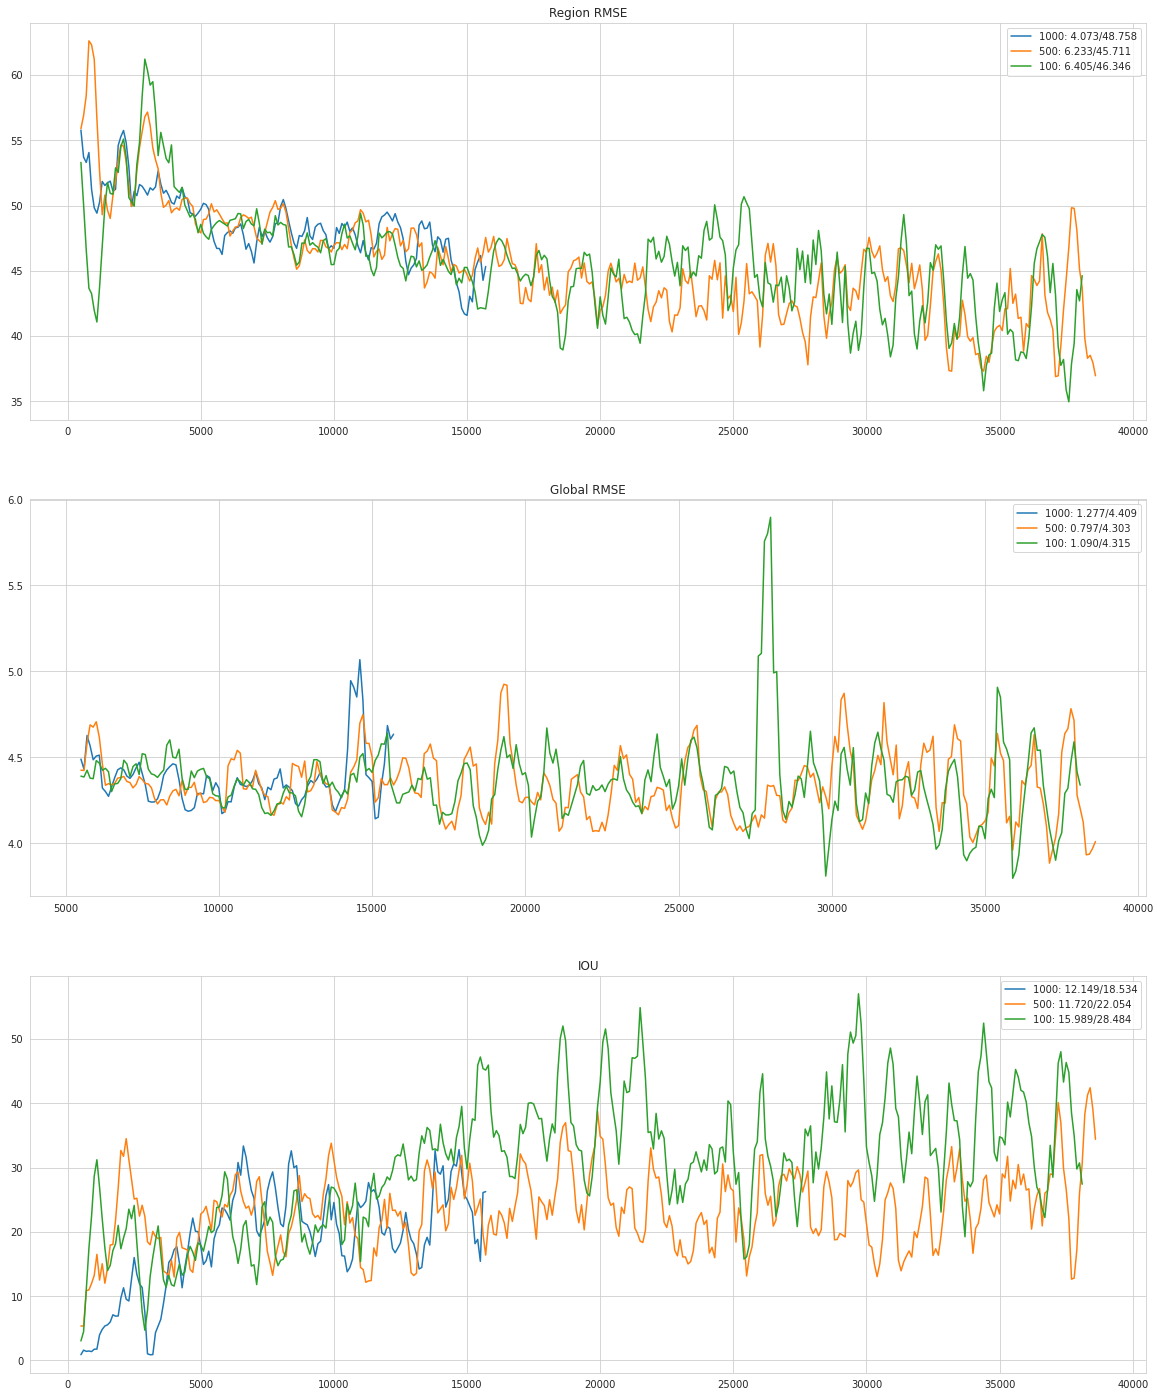

In [37]:
rm=5
plt.subplots(figsize=(20,10))
plt.subplot(3,1,1)
plt.title("Region RMSE")
data = [('1000', df_spec_score_region_010), 
        ('500', df_spec_score_region_011), 
        ('100', df_spec_score_region_013)]
for label, d in data:
  plt.plot(d.rolling(rm).mean(), 
          label=f'{label}: {d.std()[0]:.3f}/{d.median()[0]:.3f}');
plt.legend();


plt.subplot(3,1,2)
plt.title("Global RMSE")
data = [('1000', df_spec_score_whole_010), 
        ('500', df_spec_score_whole_011), 
        ('100', df_spec_score_whole_013)]
for label, d in data:
  plt.plot(d.iloc[50:].rolling(rm).mean(), 
          label=f'{label}: {d.std()[0]:.3f}/{d.median()[0]:.3f}');
plt.legend();

plt.subplot(3,1,3)
plt.title("IOU")
data = [('1000', df_spec_iou_010), 
        ('500', df_spec_iou_011), 
        ('100', df_spec_iou_013)]
for label, d in data:
  plt.plot(d.rolling(rm).mean(), 
          label=f'{label}: {d.std()[0]:.3f}/{d.median()[0]:.3f}');
plt.legend();

plt.subplots_adjust(top=2);

- Global rmse has slow convergence and it goes flat and stay withing 4-4.5 level
  - It may say about bad background reconstruction, this should be further examined with identity loss

- Regional rmse has better convergence but becomes more volatile with time.
- IOU shows positive trend. But also becomes more volatile with time.

In average, 100 coefficient is more volatile compared to 500. (1000 must be trained to these levels)
We should train for more epochs to be sure enough about average behaviour

### Look at correlation of region rmse with iou (take from 5k steps to get rid of outliers)

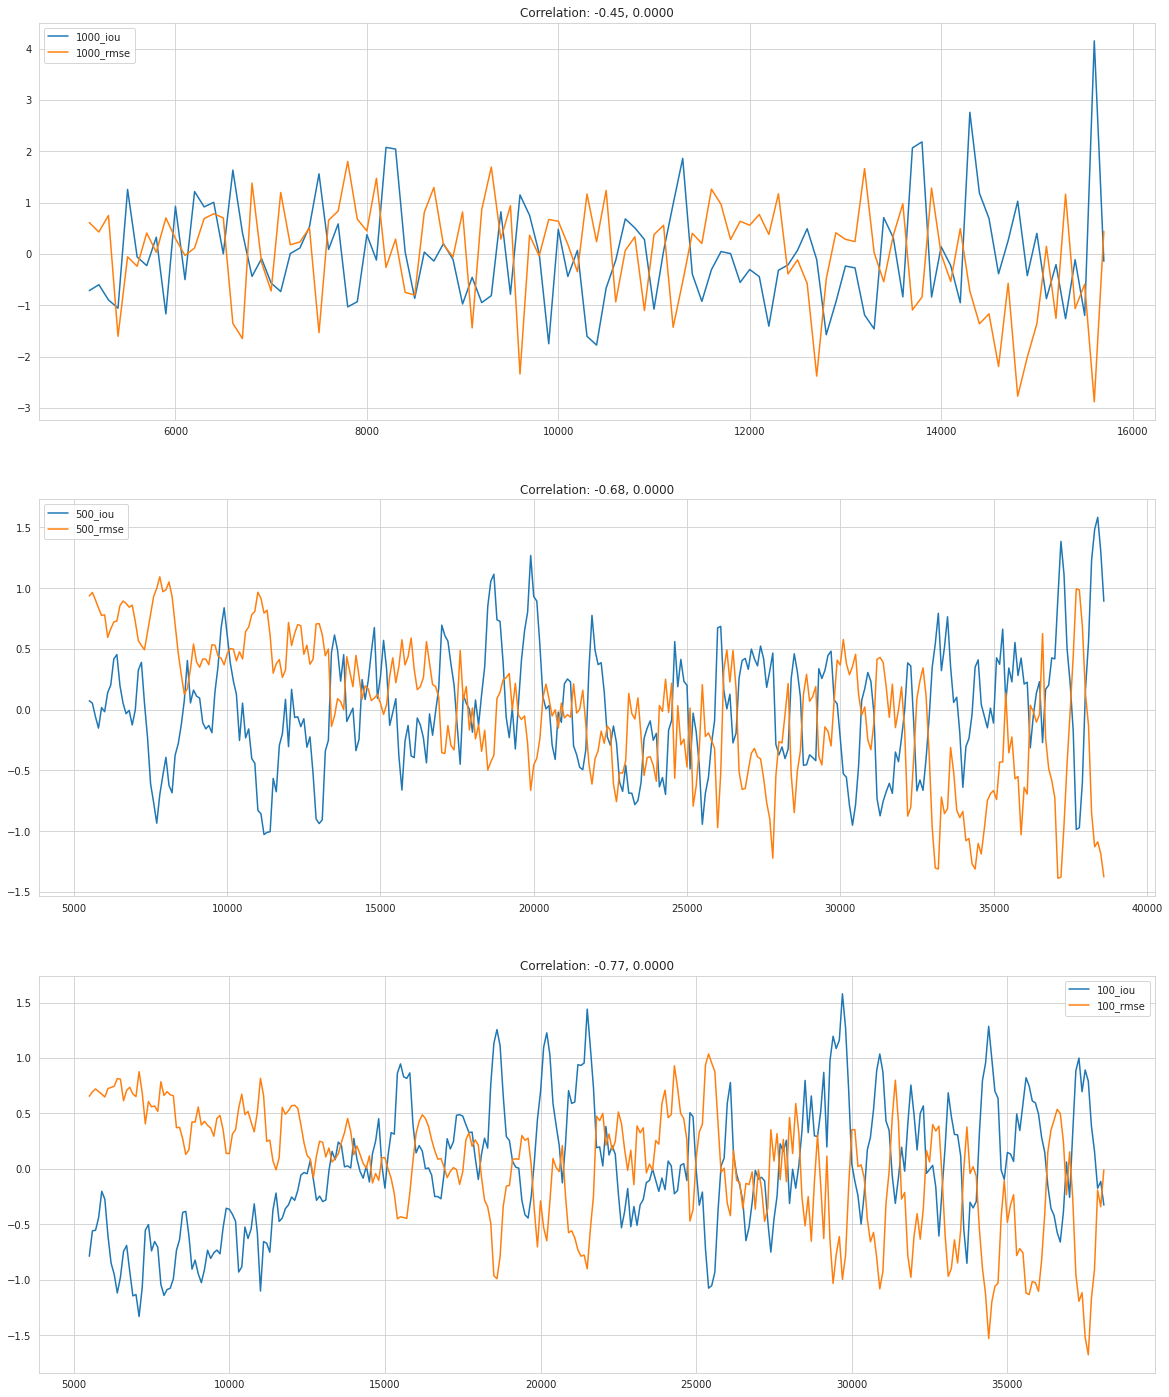

In [40]:
plt.subplots(figsize=(20,10))
data = ((1,'1000', scale(df_spec_iou_010.iloc[50:]), scale(df_spec_score_region_010.iloc[50:])),
        (5, '500',  scale(df_spec_iou_011.iloc[50:]), scale(df_spec_score_region_011.iloc[50:])),
        (5, '100',  scale(df_spec_iou_013.iloc[50:]), scale(df_spec_score_region_013.iloc[50:])))

for i,(rm, label, iou, rmse) in enumerate(data):
  plt.subplot(len(data), 1, i+1)
  corr,pv = st.pearsonr(iou.values.squeeze(), rmse.values.squeeze())
  plt.title(f"Correlation: {corr:.2f}, {pv:.4f}")
  plt.plot(iou.rolling(rm).mean(), label=f"{label}_iou")
  plt.plot(rmse.rolling(rm).mean(), label=f"{label}_rmse")
  plt.legend();

plt.subplots_adjust(top=2);

- We have a significant negative correlation for all hypothesis. However, those models with greater weight for attention gives smaller coefficients. It contradicts with the initial assumptions
- For 1000 we should train more.

### Correlation of Global RMSE with IOU

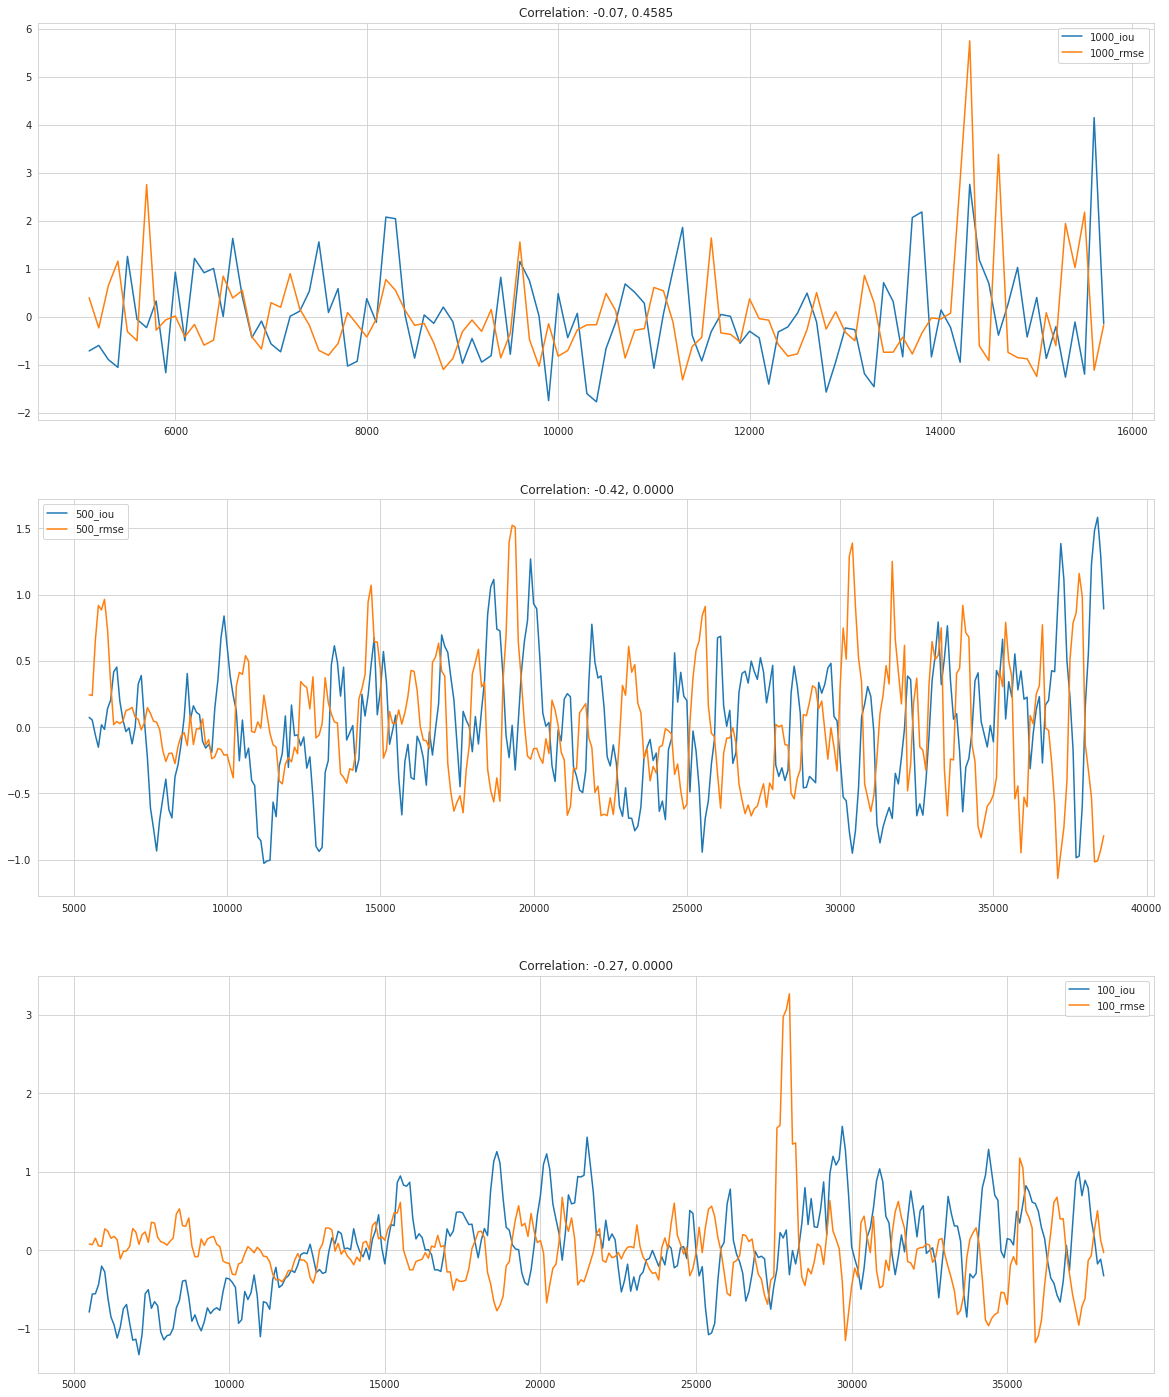

In [41]:
plt.subplots(figsize=(20,10))
data = ((1,'1000', scale(df_spec_iou_010.iloc[50:]), scale(df_spec_score_whole_010.iloc[50:])),
        (5, '500',  scale(df_spec_iou_011.iloc[50:]), scale(df_spec_score_whole_011.iloc[50:])),
        (5, '100',  scale(df_spec_iou_013.iloc[50:]), scale(df_spec_score_whole_013.iloc[50:])))

for i,(rm, label, iou, rmse) in enumerate(data):
  plt.subplot(len(data), 1, i+1)
  corr,pv = st.pearsonr(iou.values.squeeze(), rmse.values.squeeze())
  plt.title(f"Correlation: {corr:.2f}, {pv:.4f}")
  plt.plot(iou.rolling(rm).mean(), label=f"{label}_iou")
  plt.plot(rmse.rolling(rm).mean(), label=f"{label}_rmse")
  plt.legend();

plt.subplots_adjust(top=2);

### Look at losses

#### Adv. domain B

In [0]:
tag_gab = 'G/GAN_A2B'
df_spec_gab_010 = results_010[tag_gab]
df_spec_gab_011 = results_011[tag_gab]
df_spec_gab_013 = results_013[tag_gab]

tag_db_real = 'D/D_B_real'
df_spec_db_real_010 = results_010[tag_db_real]
df_spec_db_real_011 = results_011[tag_db_real]
df_spec_db_real_013 = results_013[tag_db_real]


tag_db_fake = 'D/D_B_fake'
df_spec_db_fake_010 = results_010[tag_db_fake]
df_spec_db_fake_011 = results_011[tag_db_fake]
df_spec_db_fake_013 = results_013[tag_db_fake]

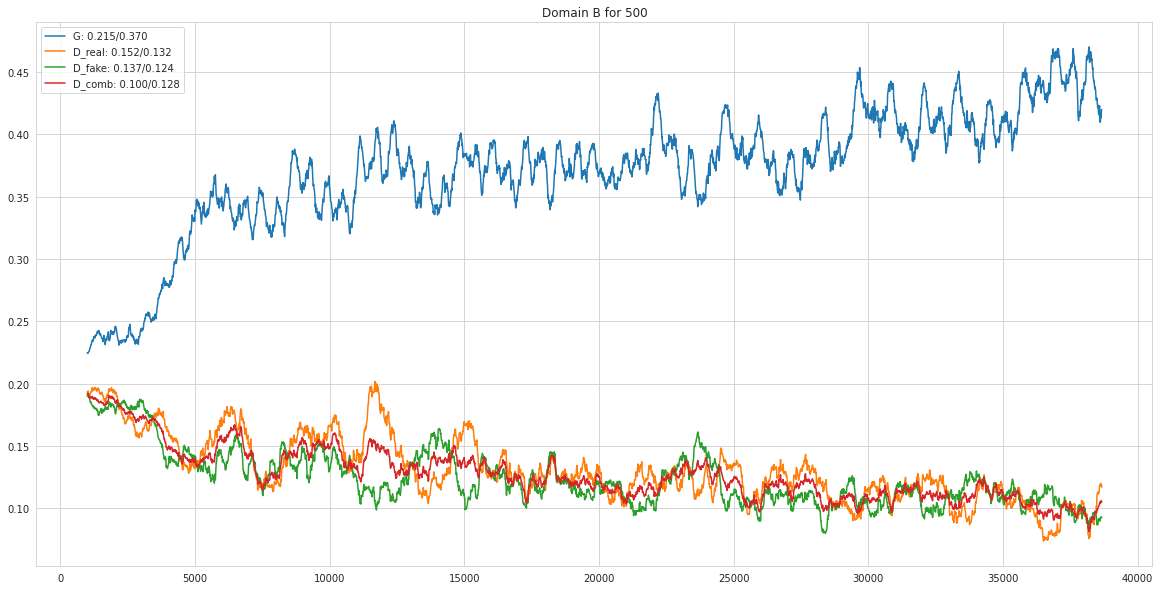

In [58]:
rm = 100
plt.subplots(figsize=(20,10))
plt.title("Domain B for 500")
plt.plot(df_spec_gab_011.rolling(rm).mean(), 
         label=f'G: {df_spec_gab_011.std()[0]:.3f}/{df_spec_gab_011.mean()[0]:.3f}');

plt.plot(df_spec_db_real_011.rolling(rm).mean(), 
         label=f'D_real: {df_spec_db_real_011.std()[0]:.3f}/{df_spec_db_real_011.mean()[0]:.3f}');
plt.plot(df_spec_db_fake_011.rolling(rm).mean(), 
         label=f'D_fake: {df_spec_db_fake_011.std()[0]:.3f}/{df_spec_db_fake_011.mean()[0]:.3f}');
# combined
df_spec_db_fake_comb_011 = (df_spec_db_real_011 + df_spec_db_fake_011) / 2
plt.plot(df_spec_db_fake_comb_011.rolling(rm).mean(), 
         label=f'D_comb: {df_spec_db_fake_comb_011.std()[0]:.3f}/{df_spec_db_fake_comb_011.mean()[0]:.3f}');
plt.legend();

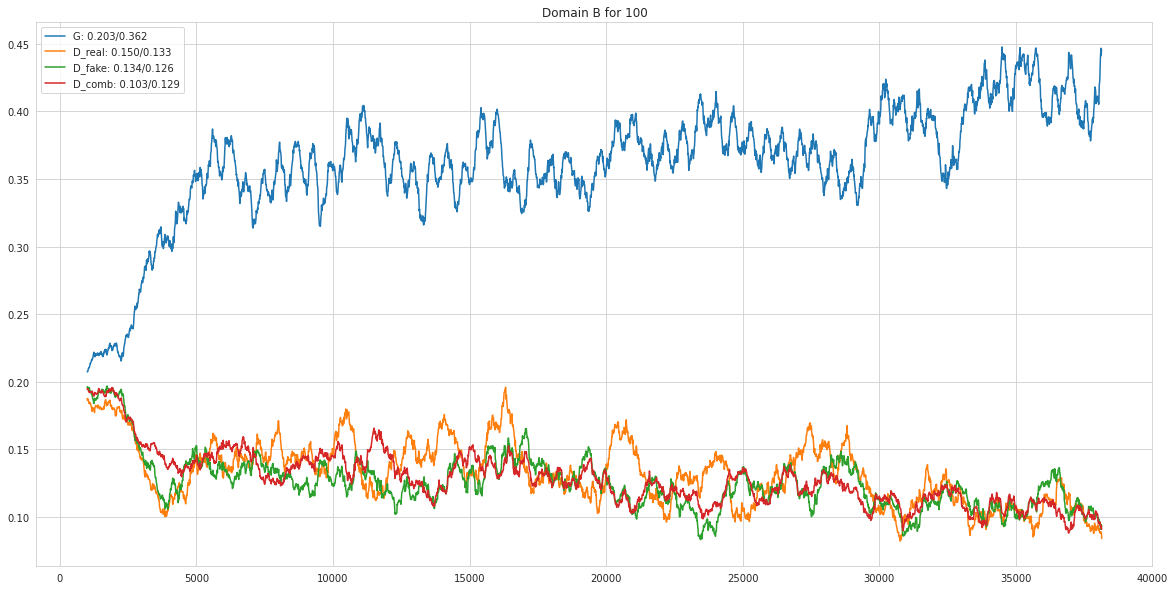

In [59]:
rm = 100
plt.subplots(figsize=(20,10))
plt.title("Domain B for 100")
plt.plot(df_spec_gab_013.rolling(rm).mean(), 
         label=f'G: {df_spec_gab_013.std()[0]:.3f}/{df_spec_gab_013.mean()[0]:.3f}');

plt.plot(df_spec_db_real_013.rolling(rm).mean(), 
         label=f'D_real: {df_spec_db_real_013.std()[0]:.3f}/{df_spec_db_real_013.mean()[0]:.3f}');
plt.plot(df_spec_db_fake_013.rolling(rm).mean(), 
         label=f'D_fake: {df_spec_db_fake_013.std()[0]:.3f}/{df_spec_db_fake_013.mean()[0]:.3f}');
# combined
df_spec_db_fake_comb_013 = (df_spec_db_real_011 + df_spec_db_fake_013) / 2
plt.plot(df_spec_db_fake_comb_013.rolling(rm).mean(), 
         label=f'D_comb: {df_spec_db_fake_comb_013.std()[0]:.3f}/{df_spec_db_fake_comb_013.mean()[0]:.3f}');
plt.legend();

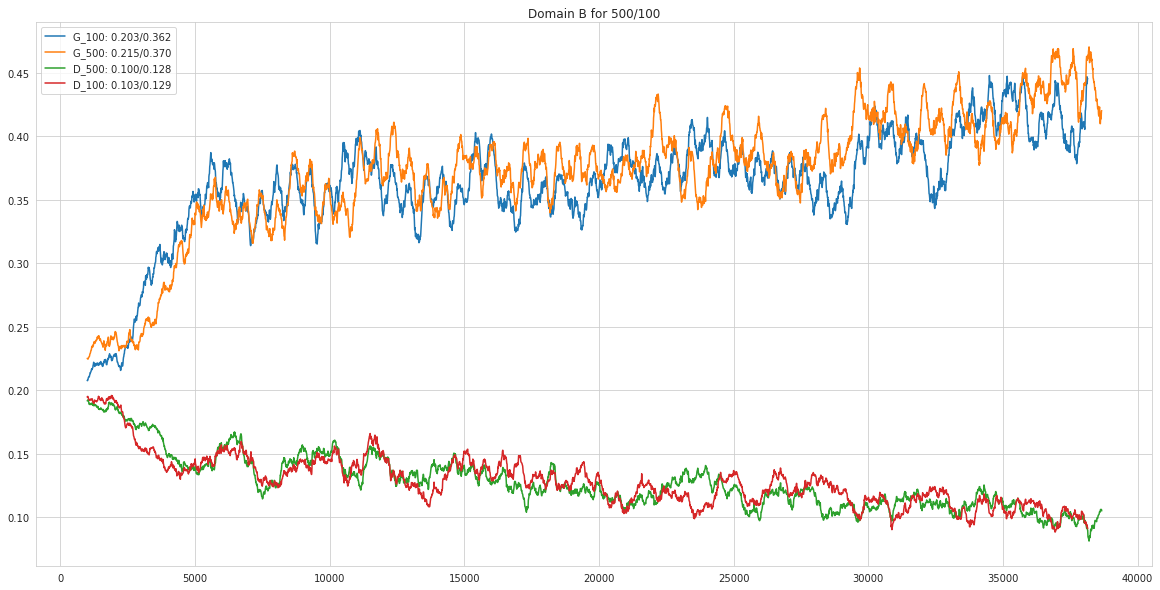

In [60]:
rm = 100
plt.subplots(figsize=(20,10))
plt.title("Domain B for 500/100")
plt.plot(df_spec_gab_013.rolling(rm).mean(), 
         label=f'G_100: {df_spec_gab_013.std()[0]:.3f}/{df_spec_gab_013.mean()[0]:.3f}');
plt.plot(df_spec_gab_011.rolling(rm).mean(), 
         label=f'G_500: {df_spec_gab_011.std()[0]:.3f}/{df_spec_gab_011.mean()[0]:.3f}');

plt.plot(df_spec_db_fake_comb_011.rolling(rm).mean(), 
         label=f'D_500: {df_spec_db_fake_comb_011.std()[0]:.3f}/{df_spec_db_fake_comb_011.mean()[0]:.3f}');
plt.plot(df_spec_db_fake_comb_013.rolling(rm).mean(), 
         label=f'D_100: {df_spec_db_fake_comb_013.std()[0]:.3f}/{df_spec_db_fake_comb_013.mean()[0]:.3f}');
plt.legend();

- Adversarial losses seem to be the same for 100/500 models and they seem to be less volatile then its dilated counterpart
- If so, then the main source of uncertainty goes from cam losses

#### Adv. domain A

In [0]:
tag_gba = 'G/GAN_B2A'
df_spec_gba_010 = results_010[tag_gba]
df_spec_gba_011 = results_011[tag_gba]
df_spec_gba_013 = results_013[tag_gba]

tag_da_real = 'D/D_A_real'
df_spec_da_real_010 = results_010[tag_db_real]
df_spec_da_real_011 = results_011[tag_db_real]
df_spec_da_real_013 = results_013[tag_db_real]


tag_da_fake = 'D/D_A_fake'
df_spec_da_fake_010 = results_010[tag_db_fake]
df_spec_da_fake_011 = results_011[tag_db_fake]
df_spec_da_fake_013 = results_013[tag_db_fake]

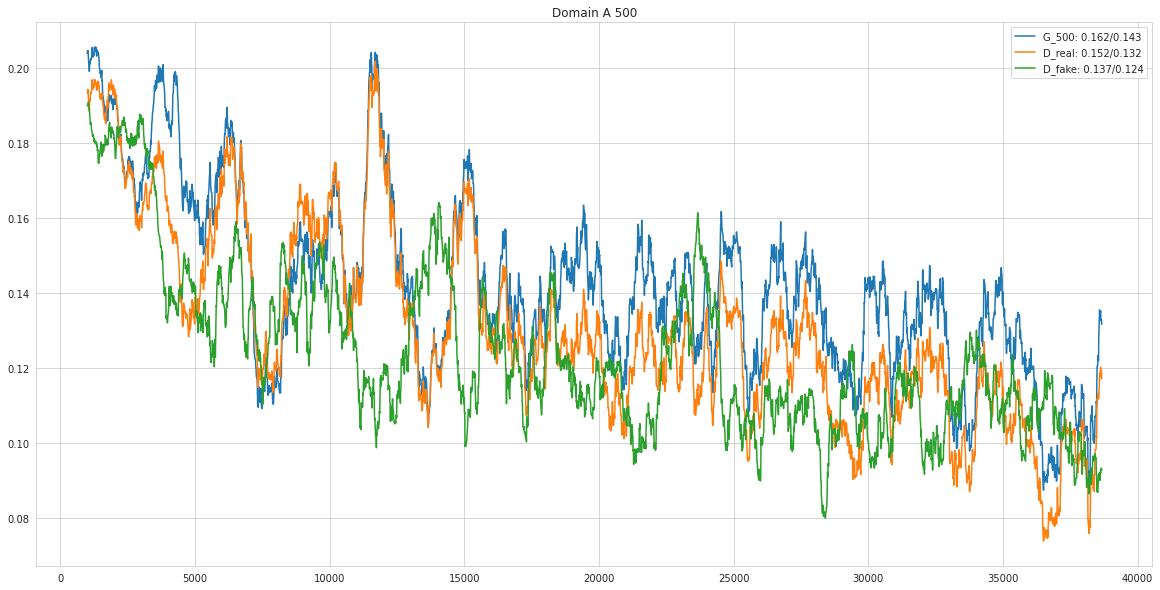

In [67]:
plt.subplots(figsize=(20,10))
rm=100
plt.title("Domain A 500")
plt.plot(df_spec_gba_011.rolling(rm).mean(), 
         label=f'G_500: {df_spec_gba_011.std()[0]:.3f}/{df_spec_gba_011.mean()[0]:.3f}');

plt.plot(df_spec_da_real_011.rolling(rm).mean(), 
         label=f'D_real: {df_spec_da_real_011.std()[0]:.3f}/{df_spec_da_real_011.mean()[0]:.3f}');
plt.plot(df_spec_da_fake_011.rolling(rm).mean(), 
         label=f'D_fake: {df_spec_da_fake_011.std()[0]:.3f}/{df_spec_da_fake_011.mean()[0]:.3f}');

# combined
df_spec_da_comb_011 = (df_spec_da_real_011 + df_spec_da_fake_011) / 2

# plt.plot(df_spec_da_comb_011.rolling(rm).mean(), 
#          label=f'D_500: {df_spec_da_comb_011.std()[0]:.3f}/{df_spec_da_comb_011.mean()[0]:.3f}');
plt.legend();

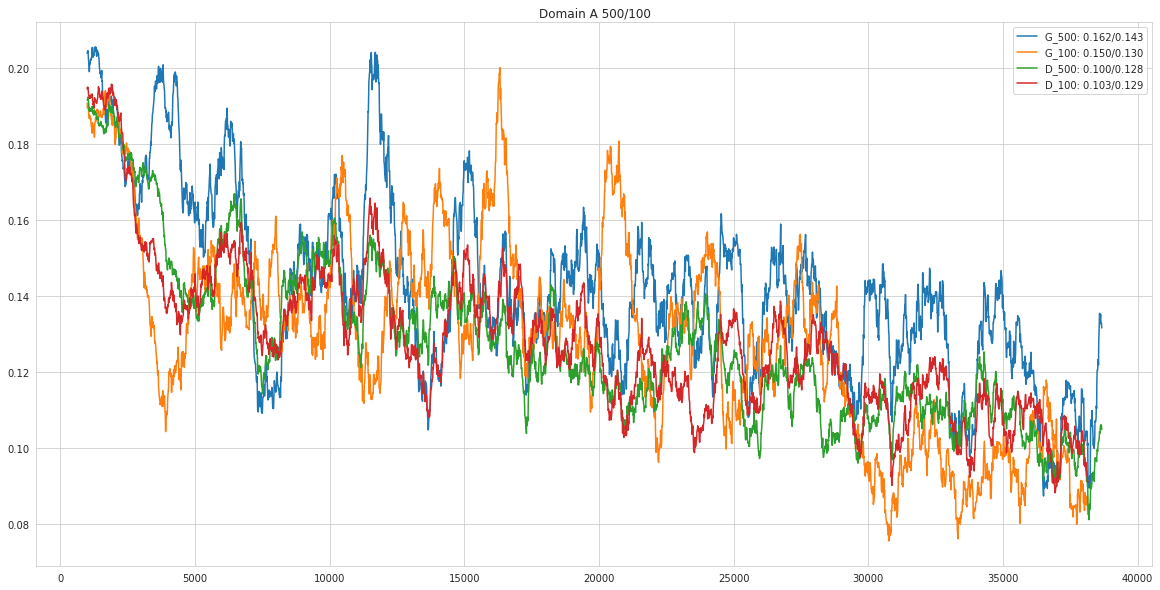

In [65]:
plt.subplots(figsize=(20,10))
rm=100
plt.title("Domain A 500/100")
plt.plot(df_spec_gba_011.rolling(rm).mean(), 
         label=f'G_500: {df_spec_gba_011.std()[0]:.3f}/{df_spec_gba_011.mean()[0]:.3f}');
plt.plot(df_spec_gba_013.rolling(rm).mean(), 
         label=f'G_100: {df_spec_gba_013.std()[0]:.3f}/{df_spec_gba_013.mean()[0]:.3f}');

# combined
df_spec_da_comb_011 = (df_spec_da_real_011 + df_spec_da_fake_011) / 2
df_spec_da_comb_013 = (df_spec_da_real_011 + df_spec_da_fake_013) / 2

plt.plot(df_spec_da_comb_011.rolling(rm).mean(), 
         label=f'D_500: {df_spec_da_comb_011.std()[0]:.3f}/{df_spec_da_comb_011.mean()[0]:.3f}');
plt.plot(df_spec_da_comb_013.rolling(rm).mean(), 
         label=f'D_100: {df_spec_da_comb_013.std()[0]:.3f}/{df_spec_da_comb_013.mean()[0]:.3f}');
plt.legend();

In [0]:
tag_idtA = 'G/cam_A2B'
df_spec_idtA_010 = results_010[tag_idtA]
df_spec_idtA_011 = results_011[tag_idtA]
df_spec_idtA_013 = results_013[tag_idtA]

tag_idtB = 'G/cam_B2A'
df_spec_idtB_010 = results_010[tag_idtB]
df_spec_idtB_011 = results_011[tag_idtB]
df_spec_idtB_013 = results_013[tag_idtB]

In [0]:
tag_idtA = 'G/idt_A'
df_spec_idtA_010 = results_010[tag_idtA]
df_spec_idtA_011 = results_011[tag_idtA]
df_spec_idtA_013 = results_013[tag_idtA]

tag_idtB = 'G/idt_B'
df_spec_idtB_010 = results_010[tag_idtB]
df_spec_idtB_011 = results_011[tag_idtB]
df_spec_idtB_013 = results_013[tag_idtB]

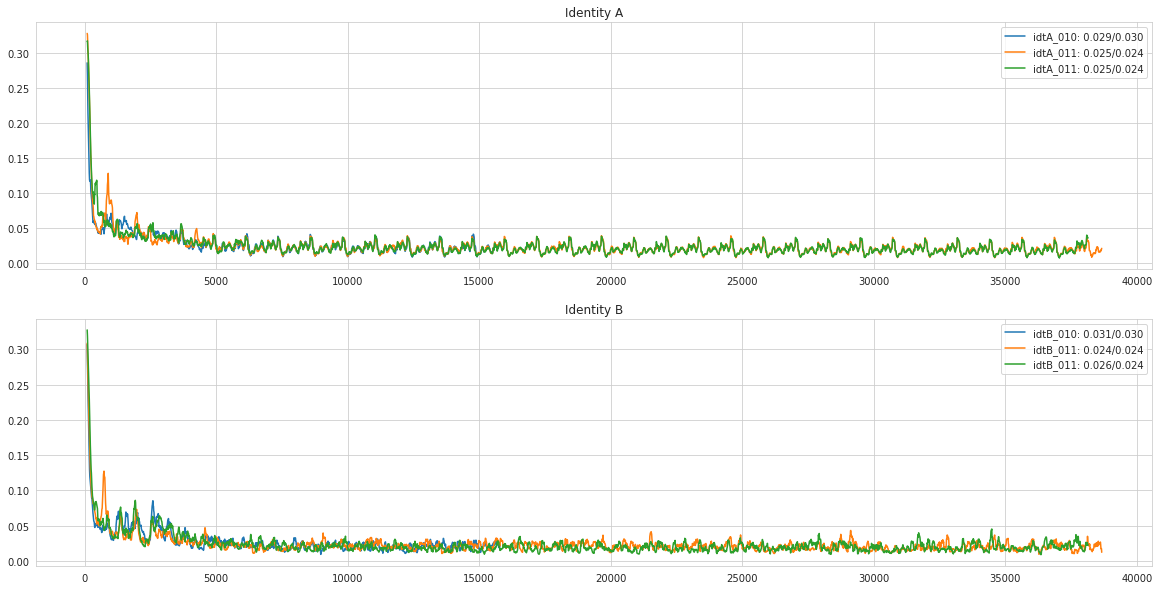

In [47]:
plt.subplots(figsize=(20,10))
rm=10

plt.subplot(2,1,1)
plt.title("Identity A")
plt.plot(df_spec_idtA_010.rolling(rm).mean(), 
         label=f'idtA_010: {df_spec_idtA_010.std()[0]:.3f}/{df_spec_idtA_010.mean()[0]:.3f}');
plt.plot(df_spec_idtA_011.rolling(rm).mean(), 
         label=f'idtA_011: {df_spec_idtA_011.std()[0]:.3f}/{df_spec_idtA_011.mean()[0]:.3f}');
plt.plot(df_spec_idtA_013.rolling(rm).mean(), 
         label=f'idtA_011: {df_spec_idtA_013.std()[0]:.3f}/{df_spec_idtA_013.mean()[0]:.3f}');
plt.legend();

plt.subplot(2,1,2)
plt.title("Identity B")
plt.plot(df_spec_idtB_010.rolling(rm).mean(), 
         label=f'idtB_010: {df_spec_idtB_010.std()[0]:.3f}/{df_spec_idtB_010.mean()[0]:.3f}');
plt.plot(df_spec_idtB_011.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_idtB_011.std()[0]:.3f}/{df_spec_idtB_011.mean()[0]:.3f}');
plt.plot(df_spec_idtB_013.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_idtB_013.std()[0]:.3f}/{df_spec_idtB_013.mean()[0]:.3f}');

plt.legend();

In [0]:
tag_ABA = 'G/cycle_ABA'
df_spec_ABA_010 = results_010[tag_ABA]
df_spec_ABA_011 = results_011[tag_ABA]
df_spec_ABA_013 = results_013[tag_ABA]

tag_BAB = 'G/cycle_BAB'
df_spec_BAB_010 = results_010[tag_BAB]
df_spec_BAB_011 = results_011[tag_BAB]
df_spec_BAB_013 = results_013[tag_BAB]

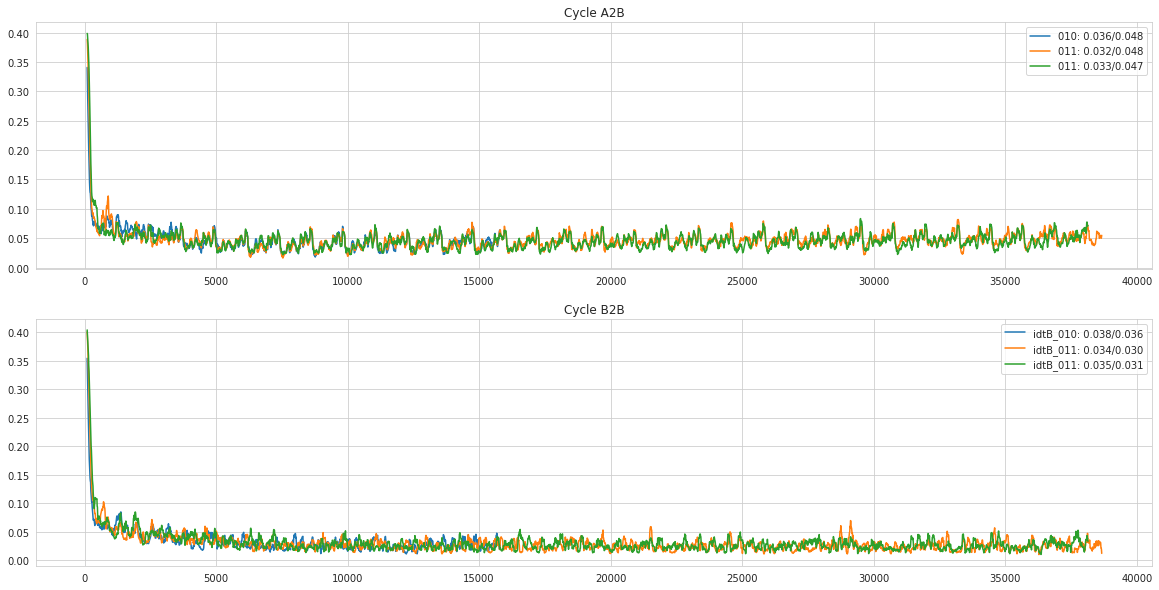

In [49]:
plt.subplots(figsize=(20,10))

plt.subplot(2,1,1)
plt.title("Cycle A2B")
plt.plot(df_spec_ABA_010.rolling(rm).mean(), 
         label=f'010: {df_spec_ABA_010.std()[0]:.3f}/{df_spec_ABA_010.mean()[0]:.3f}');
plt.plot(df_spec_ABA_011.rolling(rm).mean(), 
         label=f'011: {df_spec_ABA_011.std()[0]:.3f}/{df_spec_ABA_011.mean()[0]:.3f}');
plt.plot(df_spec_ABA_013.rolling(rm).mean(), 
         label=f'011: {df_spec_ABA_013.std()[0]:.3f}/{df_spec_ABA_013.mean()[0]:.3f}');
plt.legend();

plt.subplot(2,1,2)
plt.title("Cycle B2B")
plt.plot(df_spec_BAB_010.rolling(rm).mean(), 
         label=f'idtB_010: {df_spec_BAB_010.std()[0]:.3f}/{df_spec_BAB_010.mean()[0]:.3f}');
plt.plot(df_spec_BAB_011.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_BAB_011.std()[0]:.3f}/{df_spec_BAB_011.mean()[0]:.3f}');
plt.plot(df_spec_BAB_013.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_BAB_013.std()[0]:.3f}/{df_spec_BAB_013.mean()[0]:.3f}');

plt.legend();

### Ttest

In [0]:
import scipy.stats as st

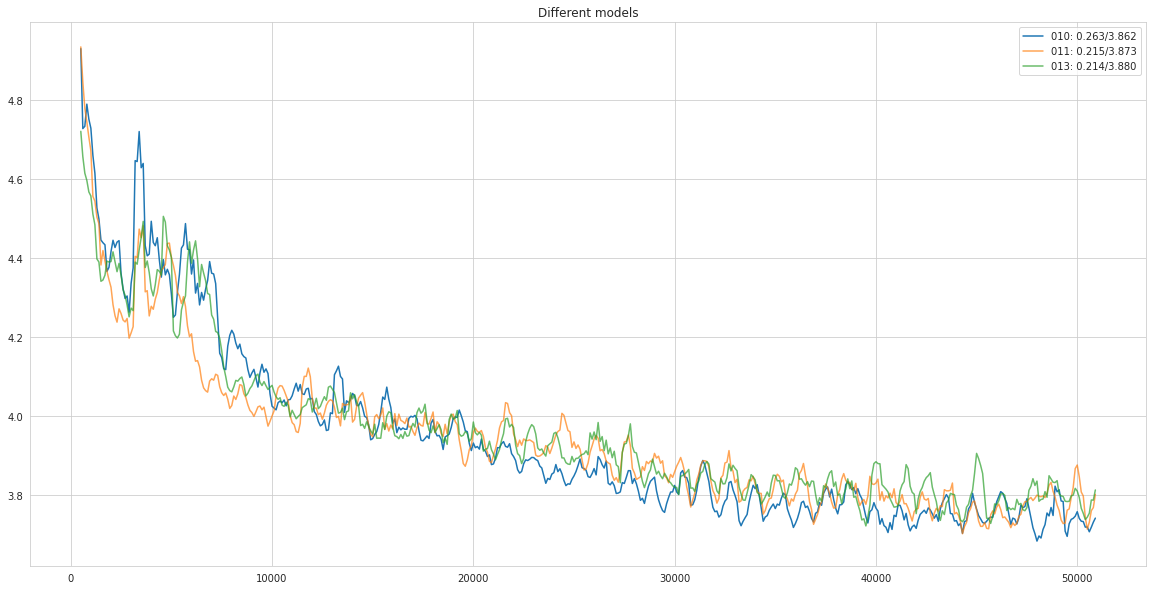

In [0]:
rm=5
plt.subplots(figsize=(20,10))
plt.title("Different models")
plt.plot(df_spec_score_010.rolling(rm).mean(), 
         label=f'010: {df_spec_score_010.std()[0]:.3f}/{df_spec_score_010.median()[0]:.3f}');
plt.plot(df_spec_score_011.rolling(rm).mean().iloc[:min_len], 
         label=f'011: {df_spec_score_011.std()[0]:.3f}/{df_spec_score_011.median()[0]:.3f}',
         alpha=0.7);
plt.plot(df_spec_score_013.rolling(rm).mean().iloc[:min_len], 
         label=f'013: {df_spec_score_013.std()[0]:.3f}/{df_spec_score_013.median()[0]:.3f}',
         alpha=0.7);
plt.legend();

In [0]:
t_1_2 = st.ttest_ind(df_spec_score_010.values, df_spec_score_011.values)
t_1_3 = st.ttest_ind(df_spec_score_010.values, df_spec_score_013.values)
t_2_3 = st.ttest_ind(df_spec_score_011.values, df_spec_score_013.values)

In [0]:
print(f'H0 vs H1: {t_1_2}\n',
      f'H0 vs H2: {t_1_3}\n',
      f"H1 vs H2: {t_2_3}")

H0 vs H1: Ttest_indResult(statistic=array([1.71926998]), pvalue=array([0.08584809]))
 H0 vs H2: Ttest_indResult(statistic=array([0.71586739]), pvalue=array([0.47422741]))
 H1 vs H2: Ttest_indResult(statistic=array([-1.14987522]), pvalue=array([0.25043187]))


In [0]:
# take values where scores are more stable
idx = 10000
t_1_2 = st.ttest_ind(df_spec_score_010[df_spec_score_010.index > idx].values, 
                     df_spec_score_011[df_spec_score_011.index > idx].values)
t_1_3 = st.ttest_ind(df_spec_score_010[df_spec_score_010.index > idx].values, 
                     df_spec_score_013[df_spec_score_013.index > idx].values)
t_2_3 = st.ttest_ind(df_spec_score_011[df_spec_score_011.index > idx].values, 
                     df_spec_score_013[df_spec_score_013.index > idx].values)

In [0]:
print("H0 mean: {:.4f}, H0 std: {:.4f}".format(df_spec_score_010[df_spec_score_010.index > idx].mean().iloc[0], 
                                       df_spec_score_010[df_spec_score_010.index > idx].std().iloc[0]))
print()
print("H1 mean: {:.4f}, H1 std: {:.4f}".format(df_spec_score_011[df_spec_score_011.index > idx].mean().iloc[0], 
                                       df_spec_score_011[df_spec_score_011.index > idx].std().iloc[0]))
print()
print("H2 mean: {:.4f}, H2 std: {:.4f}".format(df_spec_score_013[df_spec_score_013.index > idx].mean().iloc[0], 
                                       df_spec_score_013[df_spec_score_013.index > idx].std().iloc[0]))

H0 mean: 3.8456, H0 std: 0.1197

H1 mean: 3.8535, H1 std: 0.1166

H2 mean: 3.8604, H2 std: 0.1120


In [0]:
print(f'H0 vs H1: {t_1_2}\n',
      f'H0 vs H2: {t_1_3}\n',
      f"H1 vs H2: {t_2_3}")

H0 vs H1: Ttest_indResult(statistic=array([-0.98959662]), pvalue=array([0.32263908]))
 H0 vs H2: Ttest_indResult(statistic=array([-1.88904765]), pvalue=array([0.05921254]))
 H1 vs H2: Ttest_indResult(statistic=array([-0.93429577]), pvalue=array([0.35038579]))
